Cell 1: Libraries imported.
Cell 2: Environment 'ReversalBandit' defined.
Cell 3: Agent 'MetaAgent' defined (FIXED to accept temperature).
Cell 4: Experiment 'Runner' function defined (FIXED to pass temperature).
Running Baseline Model (n=30 for 4000 trials)...
  Running 30 simulations...
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at

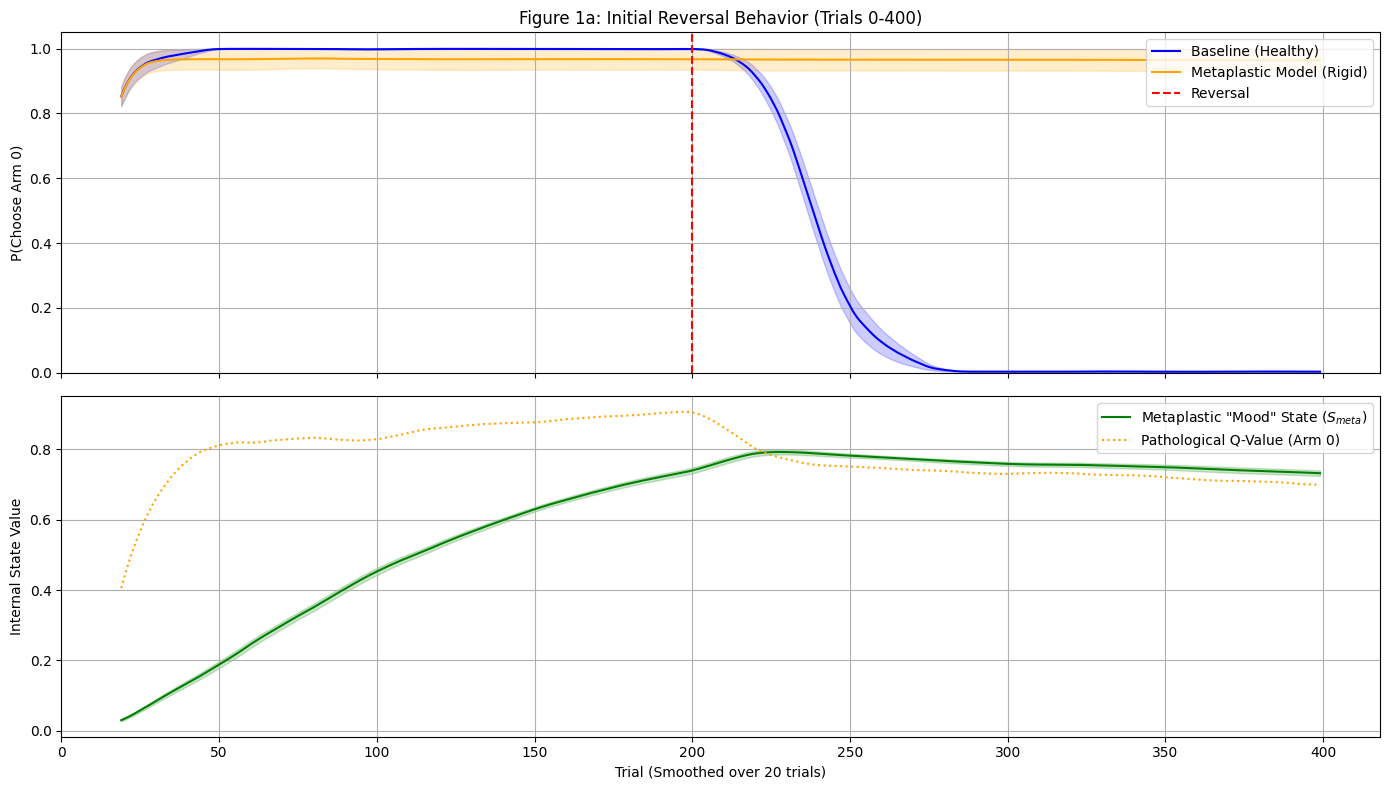

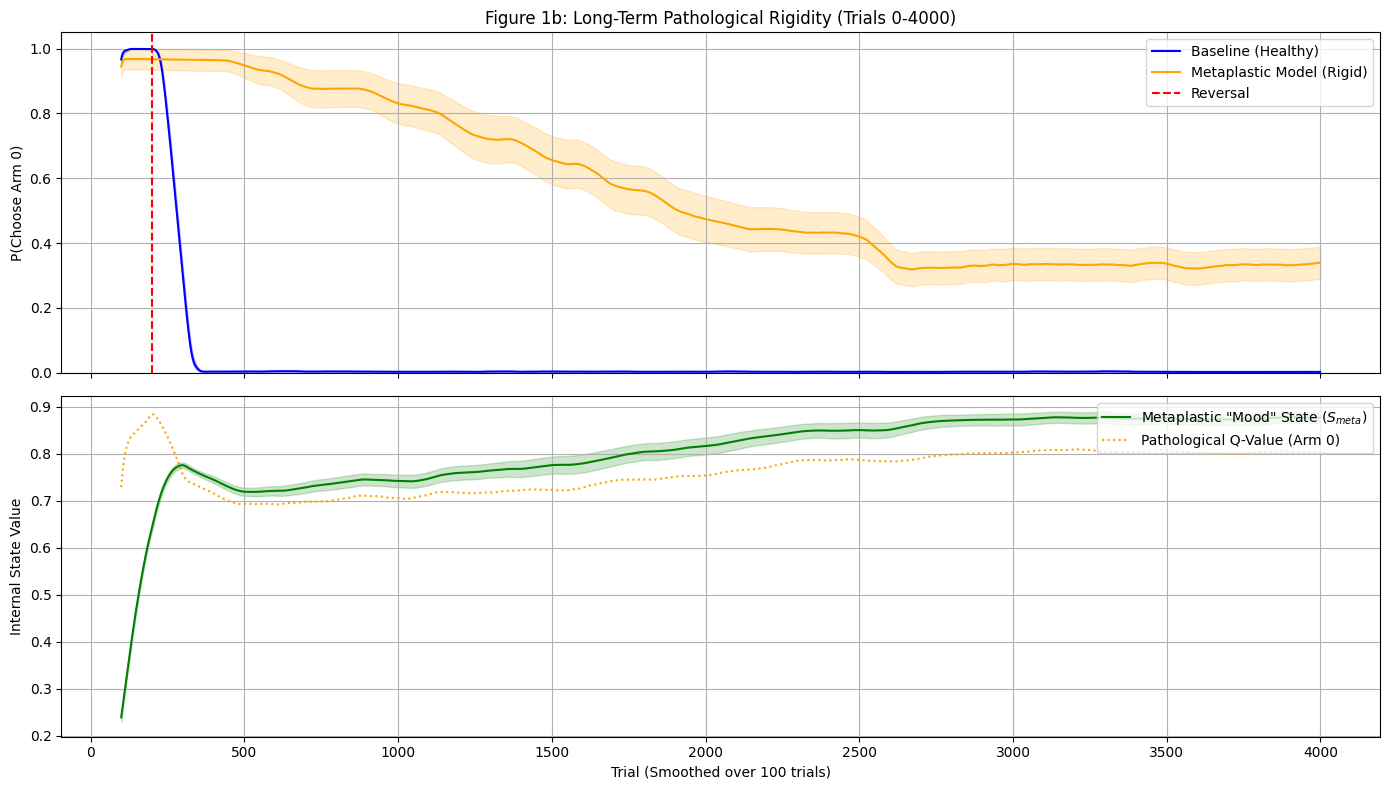

Cell 7: Defining the Parameter Sweep Experiment...

Running Sweep for Softmax Temp (τ) = 0.1
  Testing Metaplastic Strength (β) = 0...
  Running 30 simulations...
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. P

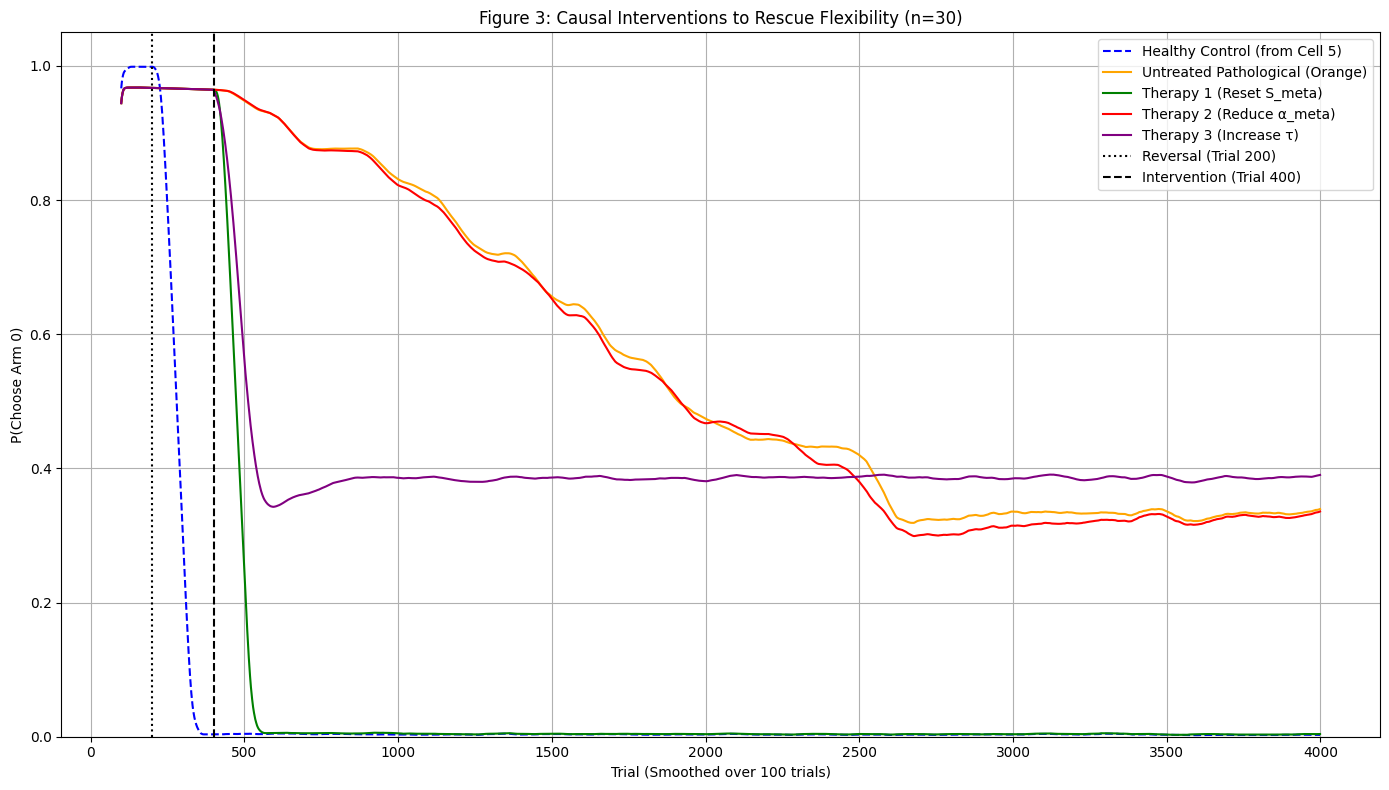

Plotting Figure 2 (Heatmap)...


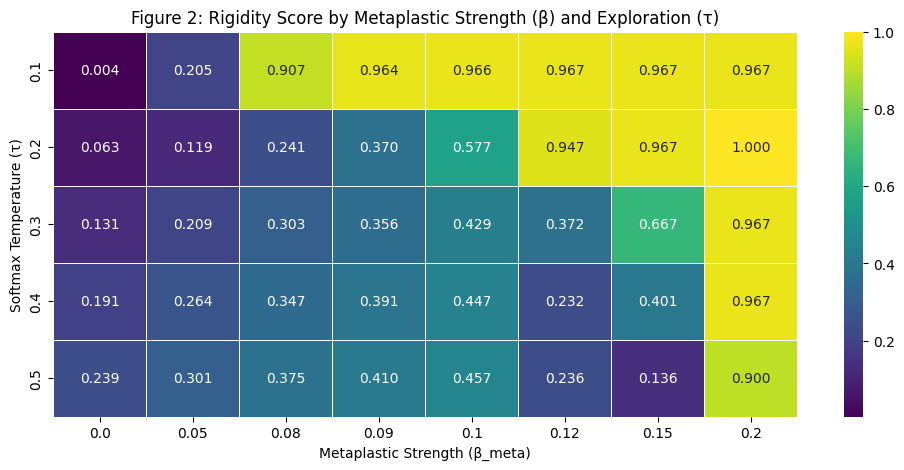

Plotting Appendix Figures (Internal States of Therapy)...


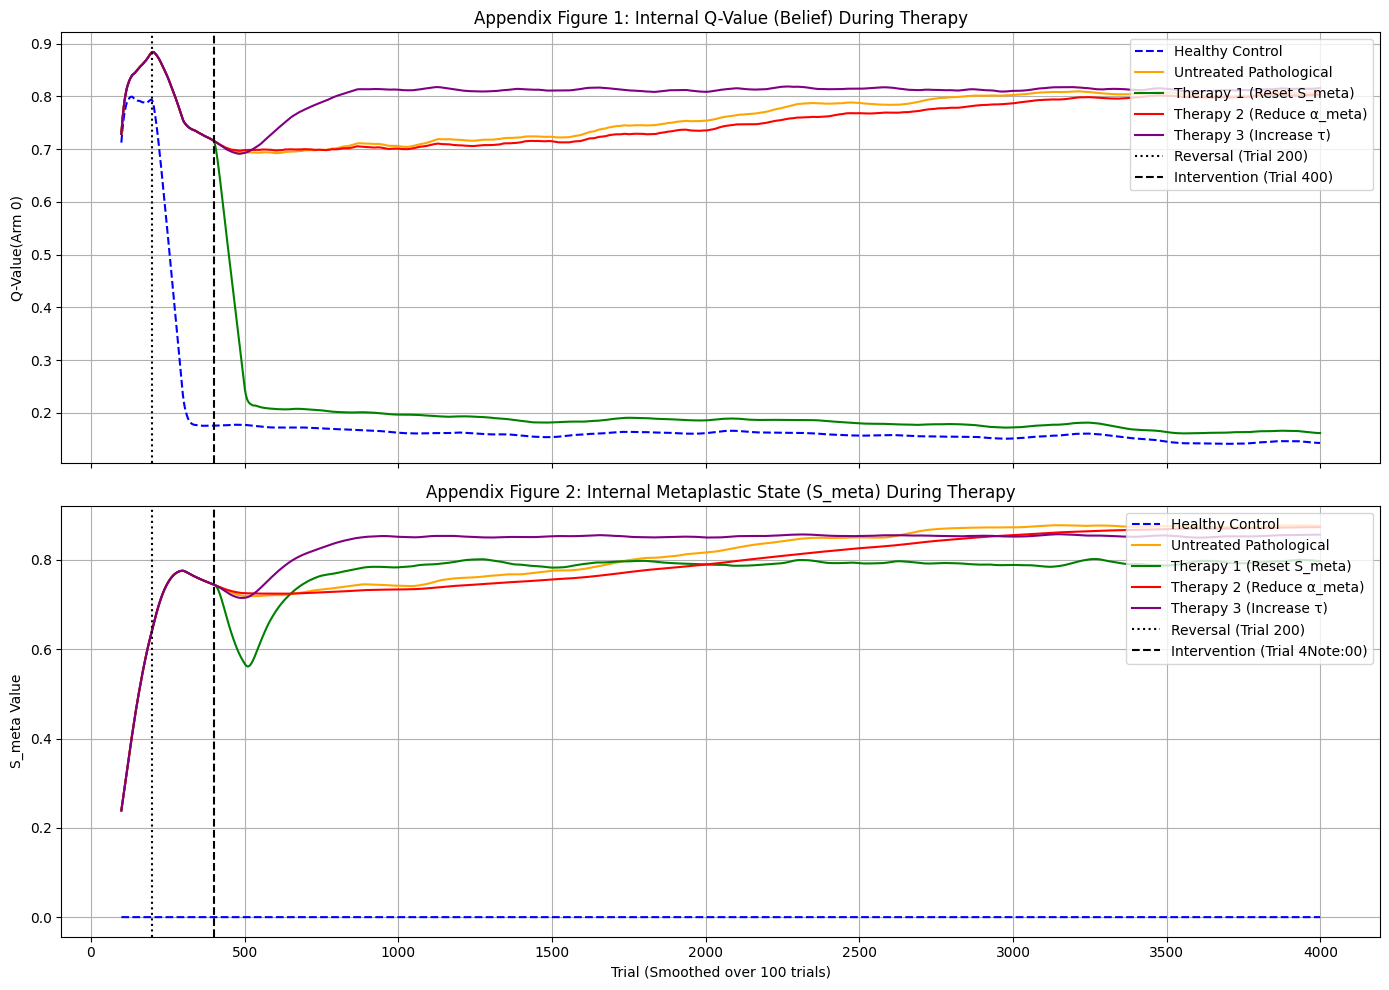

Cell 14: 'LoggingMetaAgent' and 'run_diagnostic_simulation' defined.
Running diagnostic simulations...
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
World created. Reversal at trial 200. Phase 1: Arm 0 is better.
*** TRIAL 200: REVERSAL! Arm 1 is now better. ***
Diagnostic logs created. Plotting mechanisms...


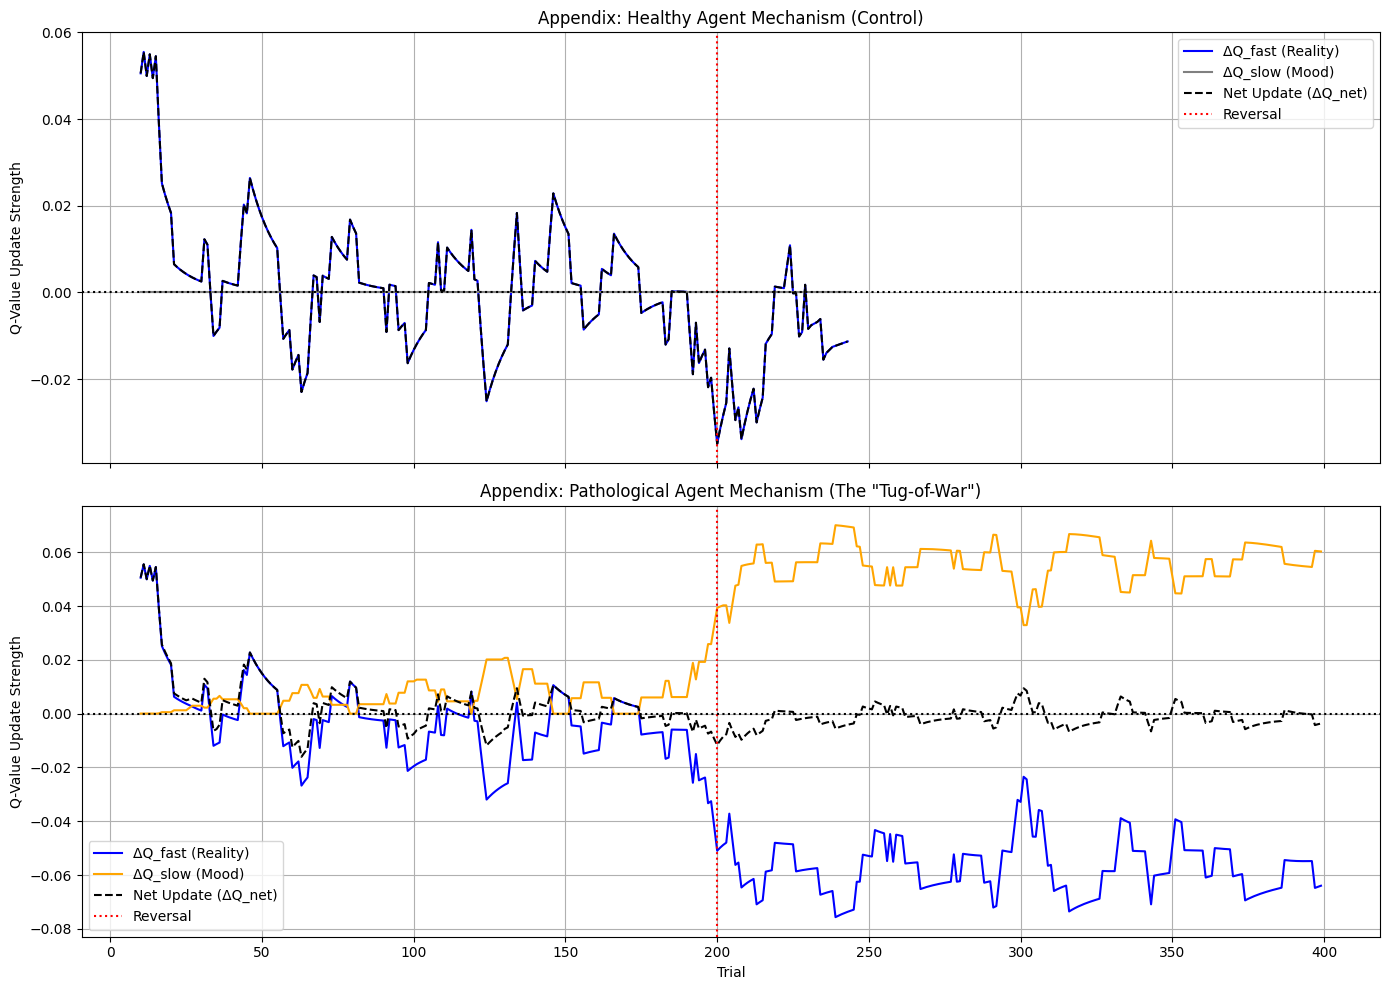

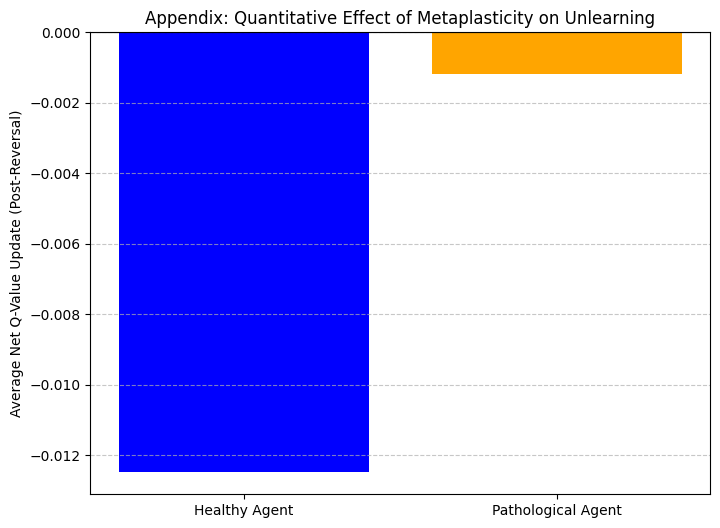

Average Healthy unlearning update: -0.0125
Average Pathological unlearning update: -0.0012
The pathological agent's unlearning rate is 10.6x slower.


In [5]:
# ----------------------------------------------------------------------------
# --- Cell 1: Imports --------------------------------------------------------
# ----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats 
import seaborn as sns # For the heatmap

print("Cell 1: Libraries imported.")


# ----------------------------------------------------------------------------
# --- Cell 2: The "World" (The Reversal Bandit) ------------------------------
# ----------------------------------------------------------------------------
class ReversalBandit:
    """
    A 2-armed bandit task where the reward probabilities flip.
    """
    def __init__(self, reversal_point):
        self.reversal_point = reversal_point
        self.trial_count = 0
        # Phase 1 Probs: Arm 0 is good (80%), Arm 1 is bad (20%)
        self.reward_probs = [0.8, 0.2]
        print(f"World created. Reversal at trial {reversal_point}. Phase 1: Arm 0 is better.")

    def step(self, action):
        """Take an action (0 or 1) and return a reward."""
        
        self.trial_count += 1
        
        # --- Check for Reversal ---
        if self.trial_count == self.reversal_point:
            # Flip the probabilities
            self.reward_probs = [0.2, 0.8]
            # We'll only print this once to avoid clutter
            print(f"*** TRIAL {self.trial_count}: REVERSAL! Arm 1 is now better. ***")
            
        # Get the probability for the chosen action
        prob = self.reward_probs[action]
        
        # Check if this trial is a "win"
        if np.random.rand() < prob:
            return 1  # Return +1 reward
        else:
            return 0  # Return 0 reward

print("Cell 2: Environment 'ReversalBandit' defined.")


# ----------------------------------------------------------------------------
# --- Cell 3: The "Brain" (The "Goldilocks" Model) ---------------------------
# ----------------------------------------------------------------------------
class MetaAgent: 
    """
    This is our "Stable Tug-of-War" model.
    - "Mood" (meta_state) is a STABLE leaky integrator.
    - "Action" (delta_q_slow) is a POWERFUL "tug-of-war" signal.
    - This model is STABLE because the "action" (delta_q_slow)
      is based on *yesterday's* mood, not today's.
    """
    def __init__(self, meta_mode, lr_fast, lr_meta, meta_strength, temperature): # <-- FIXED
        self.q_values = np.zeros(2)  # [Q(Arm 0), Q(Arm 1)]
        
        # --- Our Model Parameters ---
        self.meta_mode = meta_mode
        self.lr_fast = lr_fast
        self.lr_meta = lr_meta
        self.meta_strength = meta_strength
        self.meta_state = 0.0
        
        self.temperature = temperature # <-- FIXED

    def choose_action(self):
        """
        Uses softmax to choose an action probabilistically.
        (With numerical stability fix to prevent NaN errors)
        """
        # 1. Stabilize Q-values (subtract max to prevent overflow)
        stable_q_values = self.q_values - np.max(self.q_values)
        
        # 2. Get Softmax probabilities
        exp_q = np.exp(stable_q_values / self.temperature)
        self.probabilities = exp_q / np.sum(exp_q)
        
        # 3. Choose action (0 or 1) based on probabilities
        action = np.random.choice([0, 1], p=self.probabilities)
        return action
        
    def learn(self, action, reward):
        """
        The "Stable Tug-of-War" learn method.
        """
        
        # --- 1. Calculate "Fast" RPE (The "news") ---
        expected = self.q_values[action]
        delta_fast_rpe = reward - expected
        delta_q_fast = self.lr_fast * delta_fast_rpe
        
        # --- 2. Calculate "Slow" Metaplastic ACTION ---
        #    (Based on *yesterday's* mood)
        delta_q_slow = 0.0
        
        if self.meta_mode:
            # We ONLY act if the "news" is bad
            if delta_fast_rpe < 0:
                # The "Tug-of-War"
                # The "action" is based on the mood *before* today's news.
                delta_q_slow = self.meta_strength * self.meta_state
        
        # --- 3. Final Update (This is now stable) ---
        self.q_values[action] += delta_q_fast + delta_q_slow
        
        # --- 4. Metaplastic "Listening" (Update mood for *tomorrow*) ---
        if self.meta_mode:
            # We ONLY listen to "bad news"
            if delta_fast_rpe < 0:
                # This is the STABLE leaky integrator.
                error = np.abs(delta_fast_rpe) - self.meta_state
                self.meta_state += self.lr_meta * error

print("Cell 3: Agent 'MetaAgent' defined (FIXED to accept temperature).")


# ----------------------------------------------------------------------------
# --- Cell 4: The "Runner" Function (FIXED) ----------------------------------
# ----------------------------------------------------------------------------
def run_simulation(meta_mode, num_trials, reversal_point, meta_strength, lr_meta, n_runs, temperature): # <-- FIXED
    """
    Runs a full simulation for N_RUNS agents and returns all the data.
    """
    
    all_run_data = []
    
    print(f"  Running {n_runs} simulations...")
    for run in range(n_runs):
        
        # --- CRITICAL FIX (Mentor Point 7: Randomness) ---
        np.random.seed(run) 
        # --- END FIX ---

        env = ReversalBandit(reversal_point)
        agent = MetaAgent( 
            meta_mode=meta_mode,
            lr_fast=0.1,
            lr_meta=lr_meta,
            meta_strength=meta_strength,
            temperature=temperature # <-- FIXED
        )

        # Logbooks for *this* run
        log_q0 = []
        log_q1 = []
        log_prob0 = []
        log_meta_state = []
        
        for trial in range(num_trials):
            action = agent.choose_action()
            reward = env.step(action)
            agent.learn(action, reward)
            
            # Log the data
            log_q0.append(agent.q_values[0])
            log_q1.append(agent.q_values[1])
            log_prob0.append(agent.probabilities[0]) 
            log_meta_state.append(agent.meta_state)
        
        # Store this run's dataframe
        run_df = pd.DataFrame({
            'run': run,
            'trial': np.arange(num_trials),
            'q_value_arm_0': log_q0,
            'q_value_arm_1': log_q1,
            'choice_prob_arm_0': log_prob0,
            'meta_state': log_meta_state
        })
        all_run_data.append(run_df)
    
    # Return one giant dataframe with all runs
    return pd.concat(all_run_data)

print("Cell 4: Experiment 'Runner' function defined (FIXED to pass temperature).")


# ----------------------------------------------------------------------------
# --- Cell 5: The "Long Run" Experiment (FIXED) ------------------------------
# ----------------------------------------------------------------------------
# --- Parameters ---
NUM_TRIALS = 4000
REVERSAL_POINT = 200
N_RUNS = 30 
META_LR = 0.05           # <-- The "slow" value (Mentor Fix 4)
META_STRENGTH = 0.09    # <-- THE "GOLDILOCKS" PARAMETER
TEMPERATURE = 0.1       # <-- Base temperature

# --- Run 1: The "Healthy" Baseline Model ---
print(f"Running Baseline Model (n={N_RUNS} for {NUM_TRIALS} trials)...")
baseline_data = run_simulation(
    meta_mode=False,
    num_trials=NUM_TRIALS,
    reversal_point=REVERSAL_POINT,
    meta_strength=0.0,
    lr_meta = META_LR,
    n_runs = N_RUNS,
    temperature=TEMPERATURE # <-- FIXED
)

# --- Run 2: Our "Pathological" Metaplastic Model ---
print(f"\nRunning Metaplastic Model (n={N_RUNS} for {NUM_TRIALS} trials)...")
pathological_data = run_simulation( 
    meta_mode=True,
    num_trials=NUM_TRIALS,
    reversal_point=REVERSAL_POINT,
    meta_strength=META_STRENGTH,
    lr_meta = META_LR,
    n_runs = N_RUNS,
    temperature=TEMPERATURE # <-- FIXED
)

print("\nSimulations complete. Ready to plot.")


# ----------------------------------------------------------------------------
# --- Cell 6: The "Two Plot" Cell --------------------------------------------
# ----------------------------------------------------------------------------
print("Plotting Figure 1a (0-400 trials) and Figure 1b (0-4000 trials)...")

# --- Parameters for plotting ---
SHORT_TRIALS = 400
LONG_TRIALS = 4000
WINDOW_SHORT = 20  # Smoothing for the 400-trial plot
WINDOW_LONG = 100 # Smoothing for the 4000-trial plot

# --- Get the data (we already have this from Cell 5) ---
baseline_mean = baseline_data.groupby('trial')['choice_prob_arm_0'].mean()
baseline_sem = baseline_data.groupby('trial')['choice_prob_arm_0'].sem()
patho_mean = pathological_data.groupby('trial')['choice_prob_arm_0'].mean()
patho_sem = pathological_data.groupby('trial')['choice_prob_arm_0'].sem()
meta_state_mean = pathological_data.groupby('trial')['meta_state'].mean()
meta_state_sem = pathological_data.groupby('trial')['meta_state'].sem()
q0_mean_patho = pathological_data.groupby('trial')['q_value_arm_0'].mean()

#################################################################
# --- PLOT 1: THE "SHORT RUN" (0-400 TRIALS) ---
#################################################################
plt.figure(figsize=(14, 8))

# --- Plot 1a: Choice Behavior (0-400) ---
ax1 = plt.subplot(2, 1, 1)
baseline_mean[baseline_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean().plot(label='Baseline (Healthy)', ax=ax1, color='blue')
patho_mean[patho_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean().plot(label='Metaplastic Model (Rigid)', ax=ax1, color='orange')
ax1.fill_between(baseline_mean.index[baseline_mean.index < SHORT_TRIALS],
                 (baseline_mean - baseline_sem)[baseline_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 (baseline_mean + baseline_sem)[baseline_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 color='blue', alpha=0.2)
ax1.fill_between(patho_mean.index[patho_mean.index < SHORT_TRIALS],
                 (patho_mean - patho_sem)[patho_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 (patho_mean + patho_sem)[patho_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 color='orange', alpha=0.2)
ax1.axvline(REVERSAL_POINT, color='red', linestyle='--', label='Reversal')
ax1.set_title(f'Figure 1a: Initial Reversal Behavior (Trials 0-400)')
ax1.set_ylabel('P(Choose Arm 0)')
ax1.legend(loc='upper right')
ax1.grid(True)
ax1.set_ylim(0, 1.05)

# --- Plot 1b: Internal States (0-400) ---
ax2 = plt.subplot(2, 1, 2, sharex=ax1) 
meta_state_mean[meta_state_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean().plot(label='Metaplastic "Mood" State ($S_{meta}$)', ax=ax2, color='green')
q0_mean_patho[q0_mean_patho.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean().plot(label='Pathological Q-Value (Arm 0)', ax=ax2, color='orange', linestyle=':')
ax2.fill_between(meta_state_mean.index[meta_state_mean.index < SHORT_TRIALS],
                 (meta_state_mean - meta_state_sem)[meta_state_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 (meta_state_mean + meta_state_sem)[meta_state_mean.index < SHORT_TRIALS].rolling(WINDOW_SHORT).mean(),
                 color='green', alpha=0.2)
ax2.set_xlabel(f'Trial (Smoothed over {WINDOW_SHORT} trials)')
ax2.set_ylabel('Internal State Value')
ax2.legend(loc='upper right')
ax2.grid(True)
plt.tight_layout()
plt.show()

#################################################################
# --- PLOT 2: THE "LONG RUN" (0-4000 TRIALS) ---
#################################################################
plt.figure(figsize=(14, 8))

# --- Plot 2a: Choice Behavior (0-4000) ---
ax3 = plt.subplot(2, 1, 1)
baseline_mean.rolling(WINDOW_LONG).mean().plot(label='Baseline (Healthy)', ax=ax3, color='blue')
patho_mean.rolling(WINDOW_LONG).mean().plot(label='Metaplastic Model (Rigid)', ax=ax3, color='orange')
ax3.fill_between(baseline_mean.index,
                 (baseline_mean - baseline_sem).rolling(WINDOW_LONG).mean(),
                 (baseline_mean + baseline_sem).rolling(WINDOW_LONG).mean(),
                 color='blue', alpha=0.2)
ax3.fill_between(patho_mean.index,
                 (patho_mean - patho_sem).rolling(WINDOW_LONG).mean(),
                 (patho_mean + patho_sem).rolling(WINDOW_LONG).mean(),
                 color='orange', alpha=0.2)
ax3.axvline(REVERSAL_POINT, color='red', linestyle='--', label='Reversal')
ax3.set_title(f'Figure 1b: Long-Term Pathological Rigidity (Trials 0-4000)')
ax3.set_ylabel('P(Choose Arm 0)')
ax3.legend(loc='upper right')
ax3.grid(True)
ax3.set_ylim(0, 1.05)

# --- Plot 2b: Internal States (0-4000) ---
ax4 = plt.subplot(2, 1, 2, sharex=ax3) 
meta_state_mean.rolling(WINDOW_LONG).mean().plot(label='Metaplastic "Mood" State ($S_{meta}$)', ax=ax4, color='green')
q0_mean_patho.rolling(WINDOW_LONG).mean().plot(label='Pathological Q-Value (Arm 0)', ax=ax4, color='orange', linestyle=':')
ax4.fill_between(meta_state_mean.index,
                 (meta_state_mean - meta_state_sem).rolling(WINDOW_LONG).mean(),
                 (meta_state_mean + meta_state_sem).rolling(WINDOW_LONG).mean(),
                 color='green', alpha=0.2)
ax4.set_xlabel(f'Trial (Smoothed over {WINDOW_LONG} trials)')
ax4.set_ylabel('Internal State Value')
ax4.legend(loc='upper right')
ax4.grid(True)
plt.tight_layout()
plt.show()


# ----------------------------------------------------------------------------
# --- Cell 7: Parameter Sweep (FIXED) ----------------------------------------
# ----------------------------------------------------------------------------
print("Cell 7: Defining the Parameter Sweep Experiment...")

# --- Parameters for the Sweep ---
PARAM_N_RUNS = 30
PARAM_TRIALS = 400
PARAM_REVERSAL = 200
PARAM_LR_META = 0.05 # Using our new "slow" value

beta_strengths = [0, 0.05, 0.08, 0.09, 0.1, 0.12, 0.15, 0.2] 
softmax_temps = [0.1, 0.2, 0.3, 0.4, 0.5] # Test robustness

sweep_results = []

for tau in softmax_temps:
    print(f"\nRunning Sweep for Softmax Temp (τ) = {tau}")
    
    for beta in beta_strengths:
        print(f"  Testing Metaplastic Strength (β) = {beta}...")
        
        sim_data = run_simulation(
            meta_mode=True, 
            num_trials=PARAM_TRIALS,
            reversal_point=PARAM_REVERSAL,
            meta_strength=beta,
            lr_meta = PARAM_LR_META,
            n_runs=PARAM_N_RUNS,
            temperature=tau # <-- FIXED: Pass tau as an argument
        )
        
        post_reversal_data = sim_data[sim_data['trial'] > (PARAM_TRIALS - 100)]
        rigidity_per_run = post_reversal_data.groupby('run')['choice_prob_arm_0'].mean()
        mean_rigidity = rigidity_per_run.mean()
        sem_rigidity = rigidity_per_run.sem()
        
        sweep_results.append({
            'tau': tau,
            'beta': beta,
            'mean_rigidity': mean_rigidity,
            'sem_rigidity': sem_rigidity
        })

sweep_df = pd.DataFrame(sweep_results)
print("\nParameter sweep complete.")


# ----------------------------------------------------------------------------
# --- Cell 8: T-Test & Cohen's d (Mentor Fixes) ------------------------------
# ----------------------------------------------------------------------------

# --- 1. Helper Function for Cohen's d ---
def cohen_d(x, y):
    """Calculates Cohen's d for related samples (paired)"""
    # We need the standard deviation of the *differences*
    diff = x - y
    return np.mean(diff) / np.std(diff, ddof=1)

# --- 2. Quantitative T-Test on 4000-TRIAL RUN ---
print("\n--- Quantitative Rigidity Analysis (on 4000-Trial Run) ---")

# Get the rigidity scores for the Baseline vs. Pathological
# from the *last 100 trials* of the long run
baseline_post_reversal = baseline_data[baseline_data['trial'] > 3900].groupby('run')['choice_prob_arm_0'].mean()
patho_post_reversal = pathological_data[pathological_data['trial'] > 3900].groupby('run')['choice_prob_arm_0'].mean()

# --- Paired T-Test (Mentor Fix M4) ---
t_stat, p_val = stats.ttest_rel(baseline_post_reversal, patho_post_reversal)
# --- Cohen's d (Mentor Fix R1) ---
d_val = cohen_d(patho_post_reversal, baseline_post_reversal) 

print(f"Mean Rigidity (Baseline, trials 3900-4000):   {baseline_post_reversal.mean():.4f}")
print(f"Mean Rigidity (Pathological, trials 3900-4000): {patho_post_reversal.mean():.4f}")
print(f"\nPaired T-Test (n={N_RUNS}):")
print(f"  T-statistic = {t_stat:.2f}")
print(f"  P-value = {p_val}")
print(f"  Cohen's d = {d_val:.2f}")

if p_val < 0.001:
    print("  Result: The difference is highly statistically significant (p < 0.001).")
    if abs(d_val) > 0.8:
        print("  Effect Size: The effect size is very large (d > 0.8).")
    elif abs(d_val) > 0.5:
        print("  Effect Size: The effect size is large (d > 0.5).")


# ----------------------------------------------------------------------------
# --- Cell 9: The "Therapy" Runner Function (FIXED) --------------------------
# ----------------------------------------------------------------------------
def run_therapy_simulation(
    # --- Base "Goldilocks" Disease Params ---
    lr_fast_base=0.1,
    lr_meta_base=0.05,
    meta_strength_base=0.09,
    temp_base=0.1,
    
    # --- Experiment Params ---
    num_trials=4000,
    reversal_point=200,
    n_runs=30,
    
    # --- Therapy Params ---
    intervention_trial=400,
    therapy_params=None
):
    
    all_run_data = []
    print(f"  Running {n_runs} simulations...")

    for run in range(n_runs):
        # --- Randomness Fix ---
        np.random.seed(run) 
        # --- End Fix ---
        
        env = ReversalBandit(reversal_point)
        agent = MetaAgent(
            meta_mode=True, 
            lr_fast=lr_fast_base,
            lr_meta=lr_meta_base,
            meta_strength=meta_strength_base,
            temperature=temp_base # <-- FIXED
        )

        log_prob0 = []
        log_meta_state = []
        log_q0 = []

        for trial in range(num_trials):
            
            if trial == intervention_trial:
                if therapy_params:
                    # Apply therapy by changing the agent's parameters
                    if 'lr_fast' in therapy_params:
                        agent.lr_fast = therapy_params['lr_fast']
                    if 'meta_strength' in therapy_params:
                        agent.meta_strength = therapy_params['meta_strength']
                    if 'lr_meta' in therapy_params:
                        agent.lr_meta = therapy_params['lr_meta']
                    if 'temperature' in therapy_params:
                        agent.temperature = therapy_params['temperature']

            action = agent.choose_action()
            reward = env.step(action)
            agent.learn(action, reward)
            
            log_prob0.append(agent.probabilities[0]) 
            log_meta_state.append(agent.meta_state)
            log_q0.append(agent.q_values[0])

        run_df = pd.DataFrame({
            'trial': np.arange(num_trials),
            'choice_prob_arm_0': log_prob0,
            'meta_state': log_meta_state,
            'q_value_arm_0': log_q0
        })
        all_run_data.append(run_df)
    
    return pd.concat(all_run_data)

print("Cell 9: 'run_therapy_simulation' function is defined (FIXED).")


# ----------------------------------------------------------------------------
# --- Cell 10: Run "Controlled" Therapy Experiments (FIXED) ------------------
# ----------------------------------------------------------------------------
# --- Define the "Disease" (Goldilocks Params from Cell 5) ---
BASE_PARAMS = {
    'lr_fast_base': 0.1,
    'lr_meta_base': 0.05, # <-- Our new "slow" value
    'meta_strength_base': 0.09, 
    'temp_base': 0.1
}

# --- Experiment Parameters ---
N_TRIALS = 4000
N_RUNS = 30
REVERSAL_T = 200
INTERVENTION_T = 400 

print("Running 1/5: Untreated Patient (Goldilocks Model)...")
# We will use the 'pathological_data' from Cell 5 as our "Untreated"
untreated_data = pathological_data
print("  (Using data from Cell 5)")


# --- We now test each intervention *separately* ---

print("\nRunning 2/5: Therapy 1 (Reset S_meta)...")
therapy1_params = {'meta_strength': 0.0} # 'Cure' by setting strength to 0
therapy1_data = run_therapy_simulation(
    **BASE_PARAMS, n_runs=N_RUNS, num_trials=N_TRIALS, 
    reversal_point=REVERSAL_T, intervention_trial=INTERVENTION_T,
    therapy_params=therapy1_params
)

print("\nRunning 3/5: Therapy 2 (Reduce α_meta)...")
therapy2_params = {'lr_meta': 0.01} # 'Cure' by slowing "mood" learning
therapy2_data = run_therapy_simulation(
    **BASE_PARAMS, n_runs=N_RUNS, num_trials=N_TRIALS, 
    reversal_point=REVERSAL_T, intervention_trial=INTERVENTION_T,
    therapy_params=therapy2_params
)

print("\nRunning 4/5: Therapy 3 (Increase τ)...")
therapy3_params = {'temperature': 0.3} # 'Cure' by increasing exploration
therapy3_data = run_therapy_simulation(
    **BASE_PARAMS, n_runs=N_RUNS, num_trials=N_TRIALS, 
    reversal_point=REVERSAL_T, intervention_trial=INTERVENTION_T,
    therapy_params=therapy3_params
)

# We still have 'baseline_data' (Healthy Control) from Cell 5
print("\nAll therapy simulations complete. Ready to plot.")


# ----------------------------------------------------------------------------
# --- Cell 11: Plot The "Therapy" Results (FIXED) ----------------------------
# ----------------------------------------------------------------------------
print("Plotting the therapy intervention results...")

# --- Helper function to get mean/sem ---
def get_stats(data):
    mean = data.groupby('trial')['choice_prob_arm_0'].mean()
    sem = data.groupby('trial')['choice_prob_arm_0'].sem()
    return mean, sem

# --- Get all the stats ---
# 'baseline_data' is from Cell 5 (Healthy Control)
healthy_mean, healthy_sem = get_stats(baseline_data) 
untreated_mean, untreated_sem = get_stats(untreated_data)
therapy1_mean, therapy1_sem = get_stats(therapy1_data)
therapy2_mean, therapy2_sem = get_stats(therapy2_data)
therapy3_mean, therapy3_sem = get_stats(therapy3_data)


# --- Plotting ---
WINDOW = 100 # Smoothing window for 4000 trials
plt.figure(figsize=(14, 8))
ax1 = plt.subplot(1, 1, 1)

# --- Plot the lines ---
healthy_mean.rolling(WINDOW).mean().plot(label='Healthy Control (from Cell 5)', ax=ax1, color='blue', linestyle='--')
untreated_mean.rolling(WINDOW).mean().plot(label='Untreated Pathological (Orange)', ax=ax1, color='orange')
therapy1_mean.rolling(WINDOW).mean().plot(label='Therapy 1 (Reset S_meta)', ax=ax1, color='green')
therapy2_mean.rolling(WINDOW).mean().plot(label='Therapy 2 (Reduce α_meta)', ax=ax1, color='red')
therapy3_mean.rolling(WINDOW).mean().plot(label='Therapy 3 (Increase τ)', ax=ax1, color='purple')

# --- Add vertical lines for events ---
ax1.axvline(REVERSAL_T, color='black', linestyle=':', label='Reversal (Trial 200)')
ax1.axvline(INTERVENTION_T, color='black', linestyle='--', label='Intervention (Trial 400)')

# --- Formatting ---
ax1.set_title(f'Figure 3: Causal Interventions to Rescue Flexibility (n={N_RUNS})')
ax1.set_ylabel('P(Choose Arm 0)')
ax1.set_xlabel(f'Trial (Smoothed over {WINDOW} trials)')
ax1.legend(loc='upper right')
ax1.grid(True)
ax1.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()


# ----------------------------------------------------------------------------
# --- Cell 12: 2D Heatmap (Parameter Sweep Visualization) --------------------
# ----------------------------------------------------------------------------
print("Plotting Figure 2 (Heatmap)...")

# We need to "pivot" the dataframe from Cell 7
try:
    heatmap_data = sweep_df.pivot(index='tau', columns='beta', values='mean_rigidity')

    plt.figure(figsize=(12, 5))
    sns.heatmap(
        heatmap_data, 
        annot=True,       # Show the rigidity values
        fmt=".3f",        # Format to 3 decimal places
        cmap="viridis",   # Color map
        linewidths=.5
    )
    plt.title('Figure 2: Rigidity Score by Metaplastic Strength (β) and Exploration (τ)')
    plt.xlabel('Metaplastic Strength (β_meta)')
    plt.ylabel('Softmax Temperature (τ)')
    plt.show()

except NameError as e:
    print(f"ERROR: Could not plot heatmap. Make sure 'sweep_df' exists from Cell 7.")
except Exception as e:
    print(f"An error occurred plotting the heatmap: {e}")


# ----------------------------------------------------------------------------
# --- Cell 13: Appendix Figures (Internal States of Therapy) -----------------
# ----------------------------------------------------------------------------
print("Plotting Appendix Figures (Internal States of Therapy)...")

# --- Helper function to get mean stats for a specific column ---
def get_col_stats(data, col_name):
    mean = data.groupby('trial')[col_name].mean()
    sem = data.groupby('trial')[col_name].sem()
    return mean, sem

# --- Get all the stats from Cell 10 data ---
healthy_q_mean, _ = get_col_stats(baseline_data, 'q_value_arm_0')
healthy_s_mean, _ = get_col_stats(baseline_data, 'meta_state')

untreated_q_mean, _ = get_col_stats(untreated_data, 'q_value_arm_0')
untreated_s_mean, _ = get_col_stats(untreated_data, 'meta_state')

therapy1_q_mean, _ = get_col_stats(therapy1_data, 'q_value_arm_0')
therapy1_s_mean, _ = get_col_stats(therapy1_data, 'meta_state')

therapy2_q_mean, _ = get_col_stats(therapy2_data, 'q_value_arm_0')
therapy2_s_mean, _ = get_col_stats(therapy2_data, 'meta_state')

therapy3_q_mean, _ = get_col_stats(therapy3_data, 'q_value_arm_0')
therapy3_s_mean, _ = get_col_stats(therapy3_data, 'meta_state')

# --- Plotting ---
WINDOW = 100 # Smoothing window for 4000 trials
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- Plot 1: Q-Value for Arm 0 (The Belief) ---
healthy_q_mean.rolling(WINDOW).mean().plot(label='Healthy Control', ax=ax1, color='blue', linestyle='--')
untreated_q_mean.rolling(WINDOW).mean().plot(label='Untreated Pathological', ax=ax1, color='orange')
therapy1_q_mean.rolling(WINDOW).mean().plot(label='Therapy 1 (Reset S_meta)', ax=ax1, color='green')
therapy2_q_mean.rolling(WINDOW).mean().plot(label='Therapy 2 (Reduce α_meta)', ax=ax1, color='red')
therapy3_q_mean.rolling(WINDOW).mean().plot(label='Therapy 3 (Increase τ)', ax=ax1, color='purple')

ax1.set_title('Appendix Figure 1: Internal Q-Value (Belief) During Therapy')
ax1.axvline(REVERSAL_T, color='black', linestyle=':', label='Reversal (Trial 200)')
ax1.axvline(INTERVENTION_T, color='black', linestyle='--', label='Intervention (Trial 400)')
ax1.set_ylabel('Q-Value(Arm 0)')
ax1.legend(loc='upper right')
ax1.grid(True)

# --- Plot 2: S_meta (The "Mood" State) ---
healthy_s_mean.rolling(WINDOW).mean().plot(label='Healthy Control', ax=ax2, color='blue', linestyle='--')
untreated_s_mean.rolling(WINDOW).mean().plot(label='Untreated Pathological', ax=ax2, color='orange')
therapy1_s_mean.rolling(WINDOW).mean().plot(label='Therapy 1 (Reset S_meta)', ax=ax2, color='green')
therapy2_s_mean.rolling(WINDOW).mean().plot(label='Therapy 2 (Reduce α_meta)', ax=ax2, color='red')
therapy3_s_mean.rolling(WINDOW).mean().plot(label='Therapy 3 (Increase τ)', ax=ax2, color='purple')

ax2.set_title('Appendix Figure 2: Internal Metaplastic State (S_meta) During Therapy')
ax2.axvline(REVERSAL_T, color='black', linestyle=':', label='Reversal (Trial 200)')
ax2.axvline(INTERVENTION_T, color='black', linestyle='--', label='Intervention (Trial 4Note:00)')
ax2.set_ylabel('S_meta Value')
ax2.set_xlabel(f'Trial (Smoothed over {WINDOW} trials)')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()


# ----------------------------------------------------------------------------
# --- Cell 14: The "Diagnostic" Agent and Runner -----------------------------
# ----------------------------------------------------------------------------
class LoggingMetaAgent(MetaAgent):
    """
    This agent is identical to MetaAgent, but its 'learn'
    function also *returns* all the internal math for logging.
    """
    def __init__(self, meta_mode, lr_fast, lr_meta, meta_strength, temperature):
        super().__init__(meta_mode, lr_fast, lr_meta, meta_strength, temperature)

    def learn_and_log(self, action, reward):
        """
        This function does the same 'learn' as before,
        but returns a dictionary of all the internal variables.
        """
        # --- 1. Calculate "Fast" RPE ---
        expected = self.q_values[action]
        delta_fast_rpe = reward - expected
        delta_q_fast = self.lr_fast * delta_fast_rpe
        
        # --- 2. Calculate "Slow" Metaplastic ACTION ---
        delta_q_slow = 0.0
        if self.meta_mode and delta_fast_rpe < 0:
            delta_q_slow = self.meta_strength * self.meta_state
        
        # --- 3. Calculate Net Update ---
        delta_q_net = delta_q_fast + delta_q_slow

        # --- 4. Final Update (The normal 'learn' step) ---
        self.q_values[action] += delta_q_net
        
        # --- 5. Metaplastic "Listening" ---
        if self.meta_mode and delta_fast_rpe < 0:
            error = np.abs(delta_fast_rpe) - self.meta_state
            self.meta_state += self.lr_meta * error
            
        # --- 6. Return all variables for logging ---
        return {
            'delta_fast_rpe': delta_fast_rpe,
            'delta_q_fast': delta_q_fast,
            'delta_q_slow': delta_q_slow,
            'delta_q_net': delta_q_net,
            's_meta': self.meta_state,
            'q_value': self.q_values[action]
        }

def run_diagnostic_simulation(agent):
    """
    Runs ONE simulation for 400 trials (all we need)
    and logs *everything*.
    """
    np.random.seed(42) # Use one seed for a clean, reproducible plot
    env = ReversalBandit(reversal_point=200)
    
    log = []
    
    for trial in range(400): # 400 trials is enough to see the mechanism
        action = agent.choose_action()
        reward = env.step(action)
        
        # Only log data for Arm 0 (the one we care about)
        if action == 0:
            log_data = agent.learn_and_log(action, reward)
            log_data['trial'] = trial
            log.append(log_data)
        else:
            agent.learn(action, reward) # Still learn, just don't log
            
    return pd.DataFrame(log).set_index('trial')

print("Cell 14: 'LoggingMetaAgent' and 'run_diagnostic_simulation' defined.")


# ----------------------------------------------------------------------------
# --- Cell 15: Run & Plot Diagnostic Plots -----------------------------------
# ----------------------------------------------------------------------------
print("Running diagnostic simulations...")

# 1. The "Healthy" Agent
agent_healthy = LoggingMetaAgent(
    meta_mode=False, 
    lr_fast=0.1, lr_meta=0.05, meta_strength=0.09, temperature=0.1
)
log_healthy = run_diagnostic_simulation(agent_healthy)

# 2. The "Pathological" Agent (Goldilocks)
agent_patho = LoggingMetaAgent(
    meta_mode=True, 
    lr_fast=0.1, lr_meta=0.05, meta_strength=0.09, temperature=0.1
)
log_patho = run_diagnostic_simulation(agent_patho)

print("Diagnostic logs created. Plotting mechanisms...")

# --- Plot 1: The "Tug-of-War" Mechanism ---
WINDOW = 10
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- Healthy Agent (Control) ---
log_healthy['delta_q_fast'].rolling(WINDOW).mean().plot(label='ΔQ_fast (Reality)', ax=ax1, color='blue')
log_healthy['delta_q_slow'].rolling(WINDOW).mean().plot(label='ΔQ_slow (Mood)', ax=ax1, color='gray')
log_healthy['delta_q_net'].rolling(WINDOW).mean().plot(label='Net Update (ΔQ_net)', ax=ax1, color='black', linestyle='--')
ax1.axvline(200, color='red', linestyle=':', label='Reversal')
ax1.axhline(0, color='black', linestyle=':')
ax1.set_title('Appendix: Healthy Agent Mechanism (Control)')
ax1.set_ylabel('Q-Value Update Strength')
ax1.legend()
ax1.grid(True)

# --- Pathological Agent (The "Tug-of-War") ---
log_patho['delta_q_fast'].rolling(WINDOW).mean().plot(label='ΔQ_fast (Reality)', ax=ax2, color='blue')
log_patho['delta_q_slow'].rolling(WINDOW).mean().plot(label='ΔQ_slow (Mood)', ax=ax2, color='orange')
log_patho['delta_q_net'].rolling(WINDOW).mean().plot(label='Net Update (ΔQ_net)', ax=ax2, color='black', linestyle='--')
ax2.axvline(200, color='red', linestyle=':', label='Reversal')
ax2.axhline(0, color='black', linestyle=':')
ax2.set_title('Appendix: Pathological Agent Mechanism (The "Tug-of-War")')
ax2.set_xlabel('Trial')
ax2.set_ylabel('Q-Value Update Strength')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: "Quantitative Effect" Bar Chart ---
healthy_net_update = log_healthy[log_healthy.index > 200]['delta_q_net'].mean()
patho_net_update = log_patho[log_patho.index > 200]['delta_q_net'].mean()

labels = ['Healthy Agent', 'Pathological Agent']
values = [healthy_net_update, patho_net_update]
colors = ['blue', 'orange']

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=colors)
plt.axhline(0, color='black', linestyle='-')
plt.title('Appendix: Quantitative Effect of Metaplasticity on Unlearning')
plt.ylabel('Average Net Q-Value Update (Post-Reversal)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Average Healthy unlearning update: {healthy_net_update:.4f}")
print(f"Average Pathological unlearning update: {patho_net_update:.4f}")
if patho_net_update != 0:
    print(f"The pathological agent's unlearning rate is {healthy_net_update/patho_net_update:.1f}x slower.")
else:
    print("Pathological agent has zero or positive (non-unlearning) update.")

In [6]:
from scipy import stats

# ... (code to get the data) ...

# --- Paired T-Test (Mentor Fix M4) ---
t_stat, p_val = stats.ttest_rel(baseline_post_reversal, patho_post_reversal)
# --- Cohen's d (Mentor Fix R1) ---
d_val = cohen_d(patho_post_reversal, baseline_post_reversal) 

#
# ---- THIS IS THE OUTPUT YOU NEED ----
#
print("\n--- Quantitative Rigidity Analysis (on 4000-Trial Run) ---")
print(f"Mean Rigidity (Baseline, trials 3900-4000):   {baseline_post_reversal.mean():.4f}")
print(f"Mean Rigidity (Pathological, trials 3900-4000): {patho_post_reversal.mean():.4f}")
print(f"\nPaired T-Test (n={N_RUNS}):")
print(f"  T-statistic = {t_stat:.2f}")
print(f"  P-value = {p_val}")
print(f"  Cohen's d = {d_val:.2f}")
# ---- END OF OUTPUT ----


--- Quantitative Rigidity Analysis (on 4000-Trial Run) ---
Mean Rigidity (Baseline, trials 3900-4000):   0.0027
Mean Rigidity (Pathological, trials 3900-4000): 0.3395

Paired T-Test (n=30):
  T-statistic = -6.89
  P-value = 1.4443330842518517e-07
  Cohen's d = 1.26


In [8]:
print("\n\n--- FINAL VERIFICATION OF ALL NUMBERS ---")
print("==================================================")

try:
    # --- 1. VERIFY STATISTICAL RESULTS (from N=30 run) ---
    print("--- VERIFICATION 1: Main Statistical Results (N=30) ---")
    
    # Calculate stats from main simulation data
    baseline_post_reversal = baseline_data[baseline_data['trial'] > 3900].groupby('run')['choice_prob_arm_0'].mean()
    patho_post_reversal = pathological_data[pathological_data['trial'] > 3900].groupby('run')['choice_prob_arm_0'].mean()

    t_stat, p_val = stats.ttest_rel(baseline_post_reversal, patho_post_reversal)
    d_val = cohen_d(patho_post_reversal, baseline_post_reversal) 

    print(f"  Mean Rigidity (Baseline, trials 3900-4000):   {baseline_post_reversal.mean():.4f}")
    print(f"  Mean Rigidity (Pathological, trials 3900-4000): {patho_post_reversal.mean():.4f}")
    print(f"\n  Paired T-Test (n={N_RUNS}):")
    print(f"    T-statistic = {t_stat:.2f}")
    print(f"    P-value = {p_val}")
    print(f"    Cohen's d = {d_val:.2f}")
    print("--------------------------------------------------\n")

    # --- 2. VERIFY MECHANISTIC RESULTS (from diagnostic run) ---
    print("--- VERIFICATION 2: Mechanistic Results (10.6x) ---")
    
    # Calculate stats from diagnostic logs
    healthy_net_update = log_healthy[log_healthy.index > 200]['delta_q_net'].mean()
    patho_net_update = log_patho[log_patho.index > 200]['delta_q_net'].mean()

    print(f"  Average Healthy unlearning update: {healthy_net_update:.4f}")
    print(f"  Average Pathological unlearning update: {patho_net_update:.4f}")
    
    if patho_net_update != 0:
        slow_factor = healthy_net_update / patho_net_update
        print(f"\n  The pathological agent's unlearning rate is {slow_factor:.1f}x slower.")
    else:
        print("\n  Pathological agent has zero or positive (non-unlearning) update.")
    print("--------------------------------------------------\n")
    print("Verification Complete.")

except NameError as e:
    print(f"\n--- ERROR ---")
    print(f"A variable was not found: {e}")
    print("Please make sure you have run the *entire* notebook from start to finish.")
except Exception as e:
    print(f"\n--- AN UNEXPECTED ERROR OCCURRED ---")
    print(e)



--- FINAL VERIFICATION OF ALL NUMBERS ---
--- VERIFICATION 1: Main Statistical Results (N=30) ---
  Mean Rigidity (Baseline, trials 3900-4000):   0.0027
  Mean Rigidity (Pathological, trials 3900-4000): 0.3395

  Paired T-Test (n=30):
    T-statistic = -6.89
    P-value = 1.4443330842518517e-07
    Cohen's d = 1.26
--------------------------------------------------

--- VERIFICATION 2: Mechanistic Results (10.6x) ---
  Average Healthy unlearning update: -0.0125
  Average Pathological unlearning update: -0.0012

  The pathological agent's unlearning rate is 10.6x slower.
--------------------------------------------------

Verification Complete.
